Final Results

* analyzing: Training time, Classification accuracy on validation set, Inference time on validation set

In [78]:
import time
from functools import partial
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
import seaborn as sns
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import get_data, get_transforms
from src.vit import Trainer, ViT
from PIL import Image

In [79]:
# Initialize an empty list to store individual dataframes
data_dir = '../data'; dataset_name = 'cifar10'; dwn = True
params_dir = f'{data_dir}/params'

dataset_dir = f'{data_dir}/{dataset_name}'
train_dir = f'{dataset_dir}/train'; test_dir = f'{dataset_dir}/test'

checkpoint_dir = f'{data_dir}/checkpoints'
log_dir = f'{data_dir}/logs'
image_dir = f'{data_dir}/images'

In [80]:
dl_kwargs = dict(shuffle=False, num_workers=0, pin_memory=True) # for the DataLoader

train_set, test_set, channels, image_size, num_classes = get_data(
    dataset_name=dataset_name, train_dir=train_dir, test_dir=test_dir, dwn=dwn
)

print(f'Channels: {channels}, Image size: {image_size}, Num. classes: {num_classes}.')
len(train_set), len(test_set)

Files already downloaded and verified
Files already downloaded and verified
Channels: 3, Image size: 32, Num. classes: 10.


(50000, 10000)

In [81]:

dataframes = []

for log_file in os.listdir(log_dir):
    if log_file.endswith(".csv"):
        parts = log_file.replace(".csv", "").split("_")
        model_name = parts[0] 
        dataset_name = parts[1]  
        
        df = pd.read_csv(os.path.join(log_dir, log_file))
        
        df["Model"] = model_name
        df["Dataset"] = dataset_name
        
        dataframes.append(df)
combined_df = pd.concat(dataframes, ignore_index=True)

print(combined_df.head())

  Model  Epoch  Training Time  Inference Time  Train Loss  Validation Loss  \
0   exp      0      48.291906        3.931082    1.757109         1.606244   
1   exp      1      47.885484        3.916740    1.498063         1.461245   
2   exp      2      48.115856        3.944540    1.397969         1.331273   
3   exp      3      47.904112        3.931446    1.333986         1.271004   
4   exp      4      48.117193        3.956665    1.281448         1.235786   

   Train Accuracy  Validation Accuracy  Dataset  
0        0.342951             0.425557  cifar10  
1        0.451547             0.467456  cifar10  
2        0.490389             0.522990  cifar10  
3        0.517823             0.545979  cifar10  
4        0.535466             0.554837  cifar10  


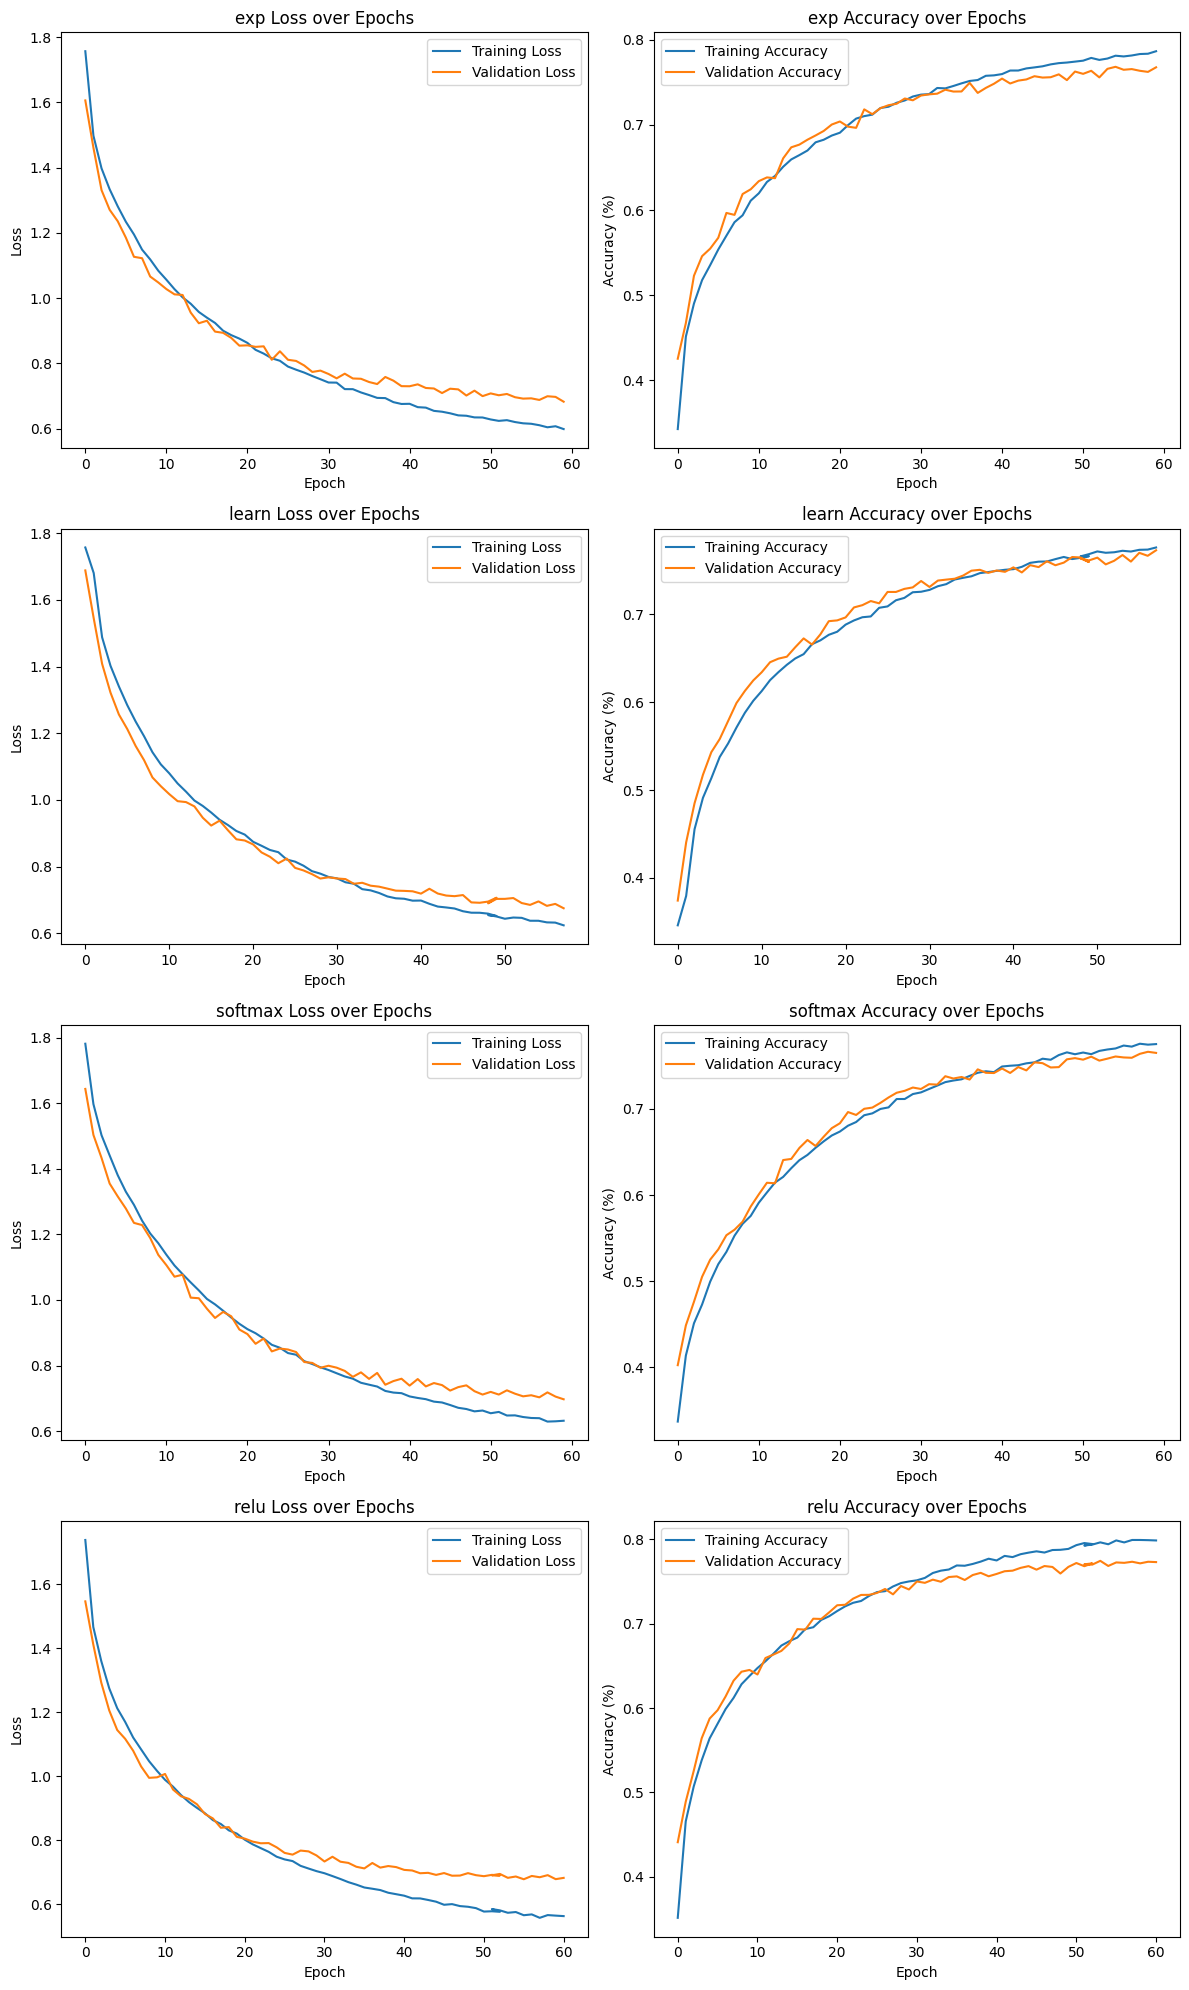

In [82]:
def plot_metrics(df, dataset_name):
    dataset_df = df[df["Dataset"] == dataset_name]
    model_names = dataset_df["Model"].unique()
    
    num_models = len(model_names)
    cols = 2  
    rows = num_models  
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, model_name in enumerate(model_names):
        metrics = dataset_df[dataset_df["Model"] == model_name]
        epochs = metrics["Epoch"]

        # Plot Loss
        ax_loss = axes[2 * i]
        ax_loss.plot(epochs, metrics["Train Loss"], label="Training Loss")
        ax_loss.plot(epochs, metrics["Validation Loss"], label="Validation Loss")
        ax_loss.set_title(f"{model_name} Loss over Epochs")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()

        # Plot Accuracy
        ax_acc = axes[2 * i + 1]
        ax_acc.plot(epochs, metrics["Train Accuracy"], label="Training Accuracy")
        ax_acc.plot(epochs, metrics["Validation Accuracy"], label="Validation Accuracy")
        ax_acc.set_title(f"{model_name} Accuracy over Epochs")
        ax_acc.set_xlabel("Epoch")
        ax_acc.set_ylabel("Accuracy (%)")
        ax_acc.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(combined_df, dataset_name="cifar10")

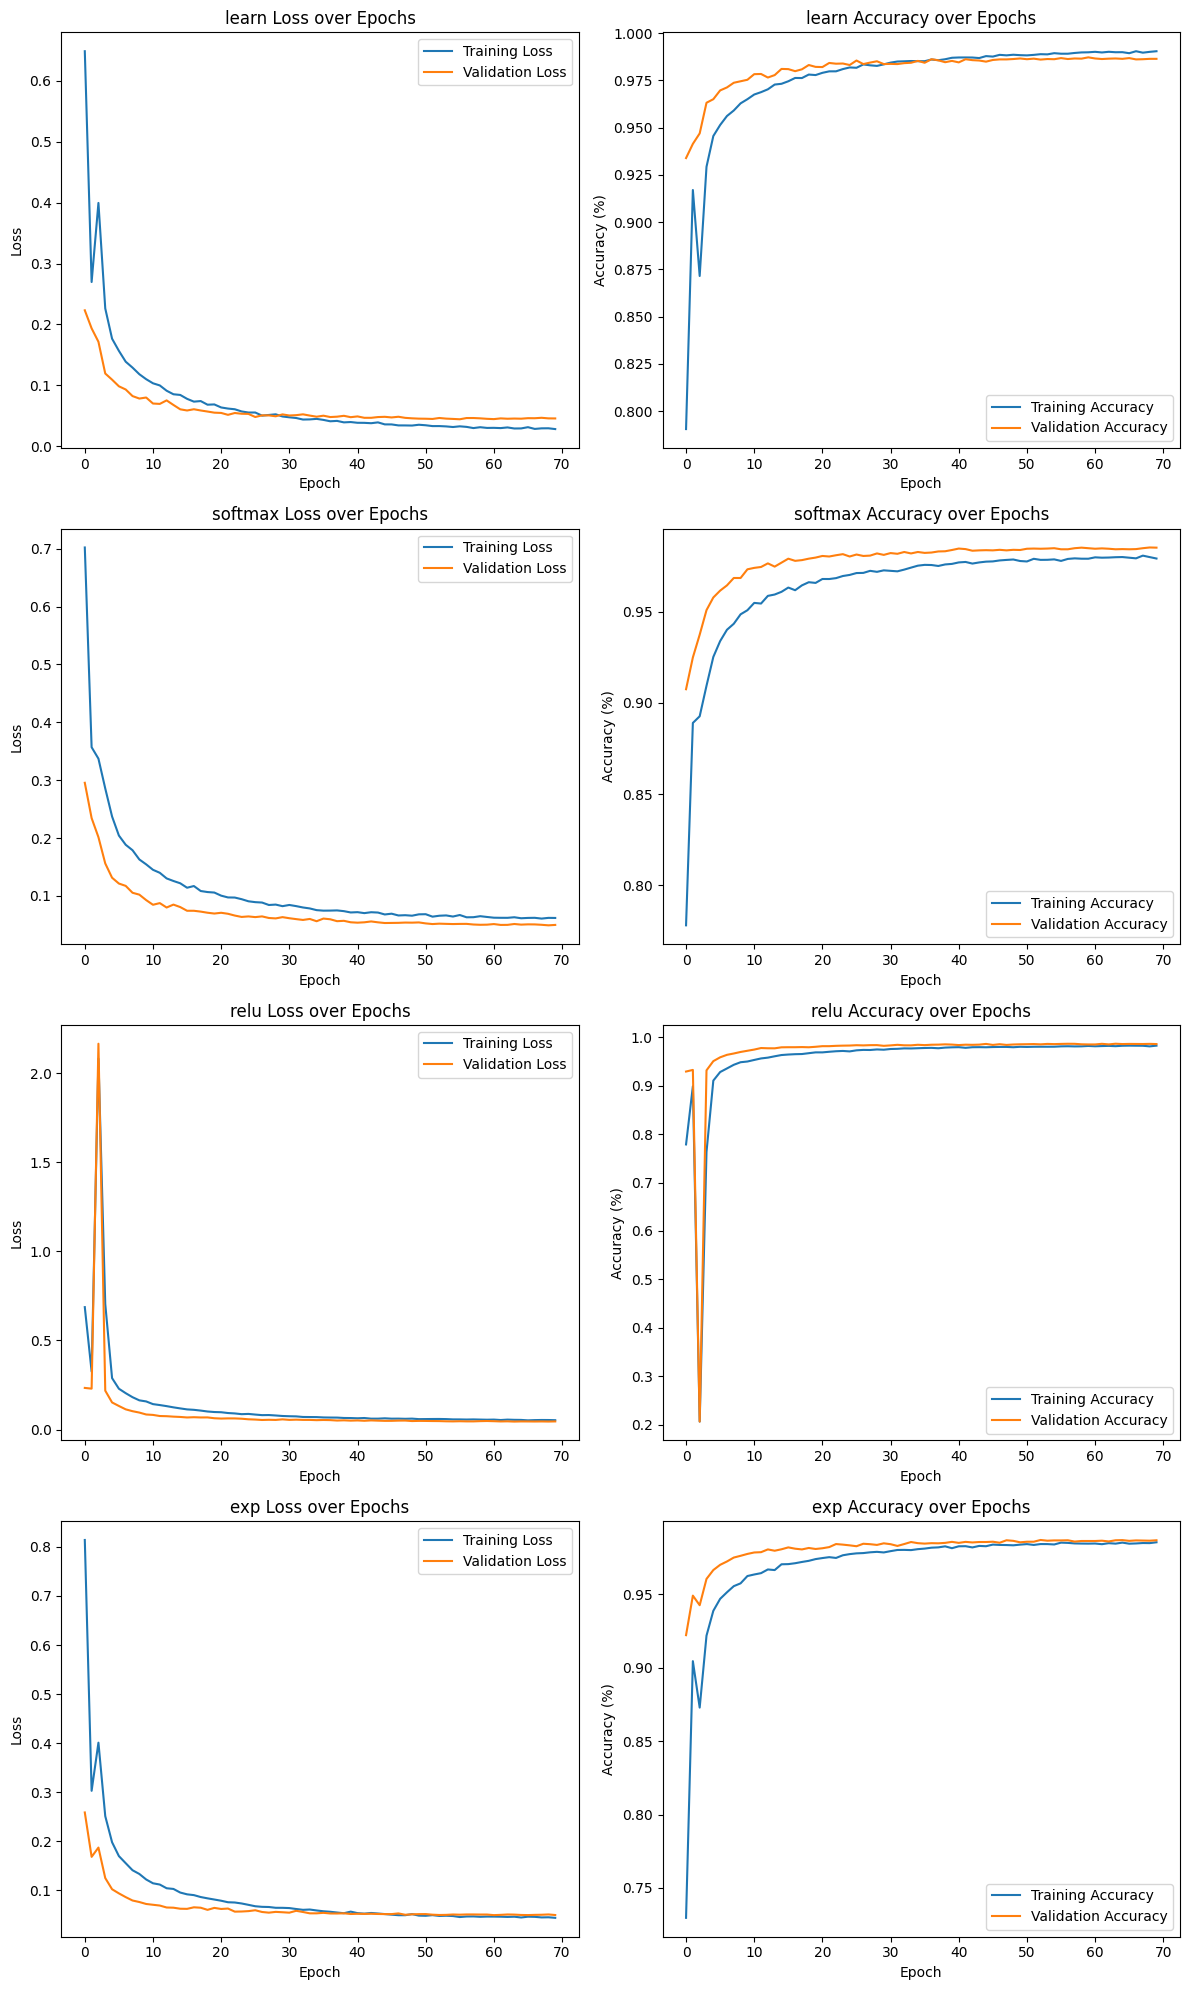

In [83]:
plot_metrics(combined_df, dataset_name="mnist")

In [84]:

def plot_comparisons(df, metric, datasets):
    df_filtered = df[df["Dataset"].isin(datasets)]
    
    num_datasets = len(datasets)
    fig, axes = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 6), sharey=True)
    
    if num_datasets == 1:
        axes = [axes]
    
    for ax, dataset in zip(axes, datasets):
        # Filter data for the current dataset
        dataset_df = df_filtered[df_filtered["Dataset"] == dataset]
        
        # Plot the bar chart
        sns.barplot(
            x="Model", y=metric, data=dataset_df, ax=ax, palette="viridis", order=dataset_df["Model"].unique()
        )
        
        # Customize the plot
        ax.set_title(f"{metric} Comparison ({dataset})")
        ax.set_xlabel("Model")
        ax.set_ylabel(metric)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

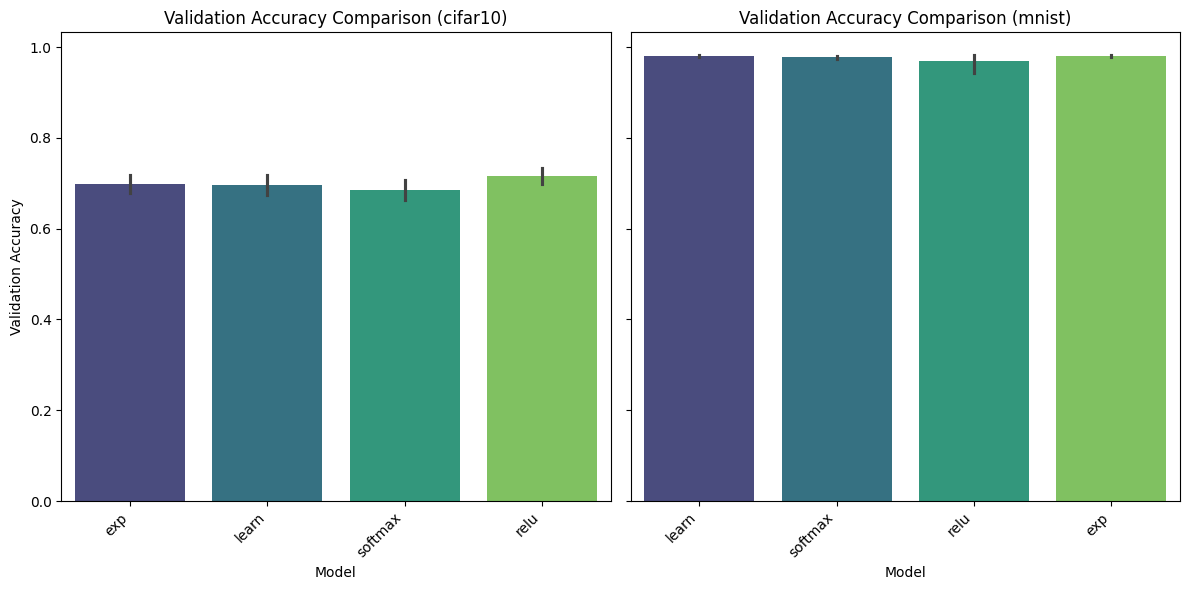

In [85]:
plot_comparisons(combined_df, metric="Validation Accuracy", datasets=["cifar10", "mnist"])

In [86]:
def plot_metrics_comparison(df, datasets):

    metrics = ["Validation Accuracy", "Training Time", "Inference Time"]

    model_order = df["Model"].unique()

    df_filtered = df[df["Dataset"].isin(datasets)]

    num_datasets = len(datasets)
    fig, axes = plt.subplots(num_datasets, len(metrics), figsize=(6 * len(metrics), 5 * num_datasets), sharey=False)
    
    if num_datasets == 1:
        axes = [axes]
    if len(metrics) == 1:
        axes = [[ax] for ax in axes]
    
    for i, dataset in enumerate(datasets):
        for j, metric in enumerate(metrics):
            ax = axes[i][j]
            
            dataset_df = df_filtered[df_filtered["Dataset"] == dataset]
            
            sns.barplot(
                x="Model", y=metric, data=dataset_df, ax=ax, palette="viridis", order=model_order
            )

            ax.set_title(f"{metric} Comparison ({dataset})")
            ax.set_xlabel("Model")
            ax.set_ylabel(metric)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

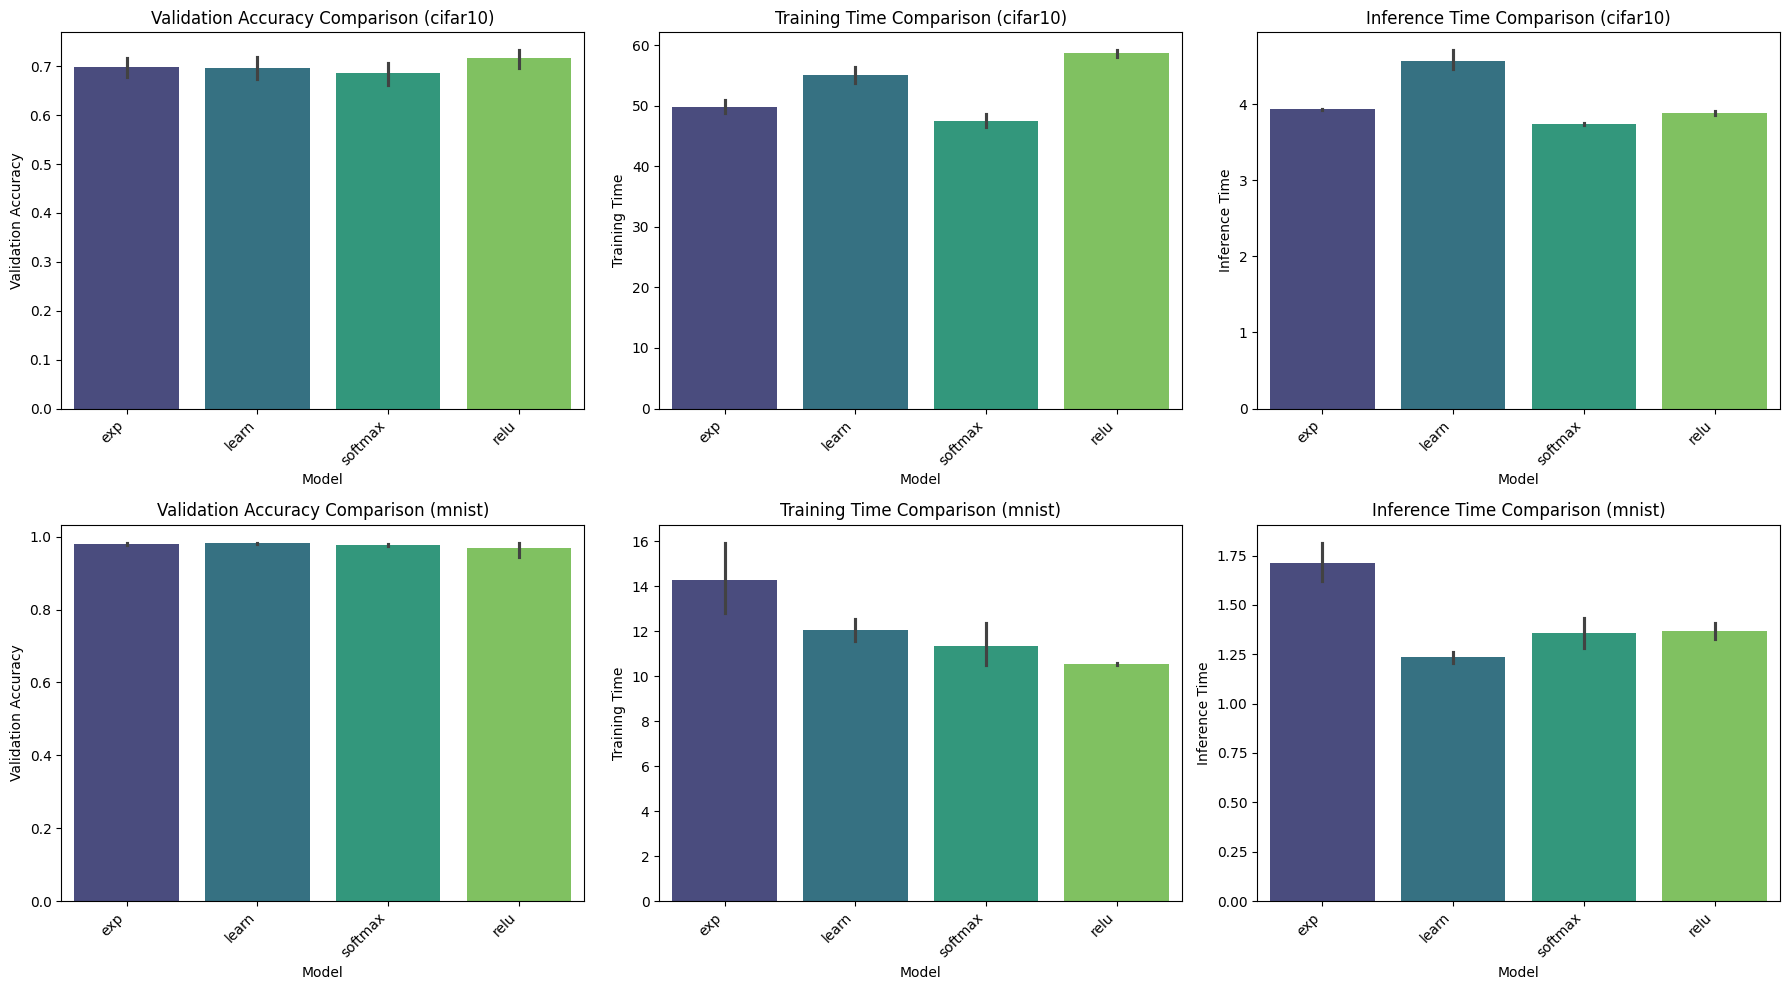

In [87]:
plot_metrics_comparison(combined_df, datasets=["cifar10", "mnist"])

In [88]:

def summary_table(df):
    # Group by Dataset and Model, calculate metrics
    summary = (
        df.groupby(["Dataset", "Model"])
        .agg(
            max_accuracy=("Validation Accuracy", "max"),
            avg_training_time=("Training Time", "mean"),
            avg_inference_time=("Inference Time", "mean")
        )
        .reset_index()
        .sort_values(by=["Dataset", "max_accuracy"], ascending=[True, False])
    )

    summary["max_accuracy"] = summary["max_accuracy"].apply(lambda x: f"{x:.2%}")
    summary["avg_training_time"] = summary["avg_training_time"].apply(lambda x: f"{x:.2f} s")
    summary["avg_inference_time"] = summary["avg_inference_time"].apply(lambda x: f"{x:.2f} s")

    summary = summary.rename(
        columns={
            "Dataset": "Dataset",
            "Model": "Model",
            "max_accuracy": "Max Accuracy",
            "avg_training_time": "Avg Training Time",
            "avg_inference_time": "Avg Inference Time"
        }
    )

    return summary

# Generate the summary table
summary_df = summary_table(combined_df)


In [89]:
summary_df

,Dataset,Model,Max Accuracy,Avg Training Time,Avg Inference Time
2,cifar10,relu,77.45%,58.64 s,3.88 s
1,cifar10,learn,77.27%,55.01 s,4.57 s
0,cifar10,exp,76.83%,49.85 s,3.93 s
3,cifar10,softmax,76.64%,47.46 s,3.74 s
5,mnist,learn,98.72%,12.04 s,1.24 s
4,mnist,exp,98.68%,14.29 s,1.71 s
6,mnist,relu,98.67%,10.54 s,1.37 s
7,mnist,softmax,98.51%,11.32 s,1.36 s


In [90]:
def load_trained_model(checkpoint_path, model_params, device='cpu', dataset_name = "cifar10", attn_type = "learn"):
    # Initialize the model with the same parameters used during training
    model = ViT(attn_type=attn_type, **model_params)

    check_path = f"{checkpoint_path}/{attn_type}_{dataset_name}"
    
    # Load the checkpoint
    checkpoint = torch.load(check_path, map_location=torch.device(device))
    
    # Load the model state dictionary
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Set the model to evaluation mode
    model.eval()
    
    print(f"Model loaded successfully from {checkpoint_path}")
    return model

In [91]:
cifar_batchsize = 64

train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)
valid_loader = DataLoader(dataset=test_set , batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

model_params_cifar10 = {
    "image_size": 32,  
    "patch_size": 4,  
    "num_classes": num_classes,
    "dim": 256,
    "depth": 4,
    "heads": 4,
    "mlp_dim": 512,
    "pool": 'cls',
    "channels": channels,
    "dim_head": 64,
    "dropout": 0.15,
    "emb_dropout": 0.15,
    "la_depth": 1, 
    "la_exp": False,      
}

attention_types = ['softmax', 'relu', 'exp', 'learn']

# Initialize models
models_cifar10 = {}
for attn_type in attention_types:
    print(f"Initializing model with attention type: {attn_type}")
    model = load_trained_model(checkpoint_path=checkpoint_dir, model_params=model_params_cifar10, device = 'mps', dataset_name = 'cifar10', attn_type = attn_type )
    models_cifar10[attn_type] = model

print(models_cifar10)

Initializing model with attention type: softmax
Model loaded successfully from ../data/checkpoints
Initializing model with attention type: relu
Model loaded successfully from ../data/checkpoints
Initializing model with attention type: exp
Model loaded successfully from ../data/checkpoints
Initializing model with attention type: learn
Model loaded successfully from ../data/checkpoints
{'softmax': ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=48, out_features=256, bias=True)
    (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.15, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      

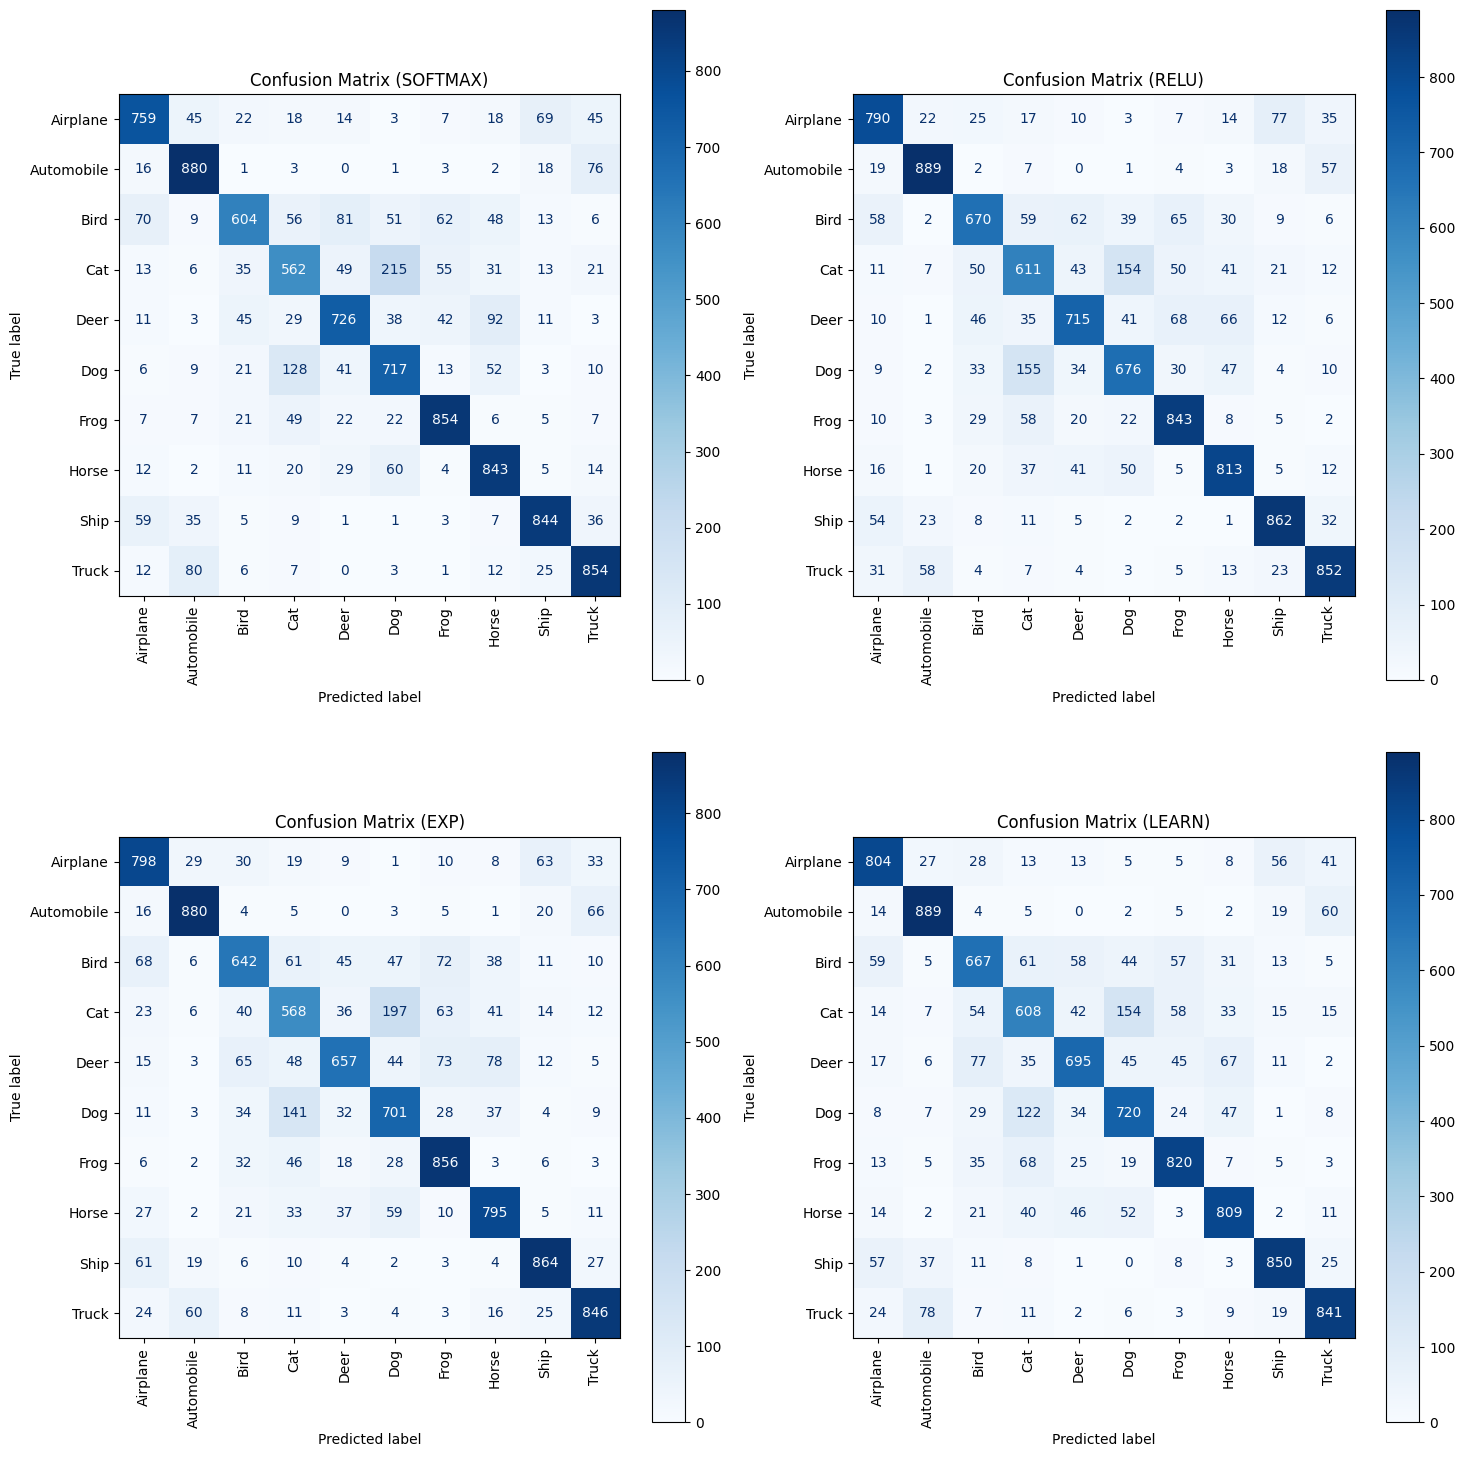

In [92]:
# Function to calculate predictions and labels
def get_predictions_and_labels(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

def plot_all_confusion_matrices(models, dataloader, class_names, device, figsize=(20, 20)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    for i, (attn_type, model) in enumerate(models.items()):
        preds, labels = get_predictions_and_labels(model, dataloader, device)
        cm = confusion_matrix(labels, preds, labels=range(len(class_names)))
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=axes[i], cmap='Blues', xticks_rotation='vertical', values_format='d')
        axes[i].set_title(f"Confusion Matrix ({attn_type.upper()})")
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

class_names = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

# Plot confusion matrices for all models in a grid
plot_all_confusion_matrices(
    models=models_cifar10,  
    dataloader=valid_loader, 
    class_names=class_names, 
    device='cpu',            

    figsize=(15, 15)        
)

In [93]:
def plot_per_class_performance(models, dataloader, class_names, device, figsize=(20, 20)):
    num_models = len(models)
    cols = 2  
    rows = (num_models + cols - 1) // cols  
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (attn_type, model) in enumerate(models.items()):
        preds, labels = get_predictions_and_labels(model, dataloader, device)
        report = classification_report(labels, preds, target_names=class_names, output_dict=True)
        metrics = pd.DataFrame(report).transpose().iloc[:-3, :-1] 

        metrics.plot(kind="bar", ax=axes[i], legend=True)
        axes[i].set_title(f"Per-Class Performance ({attn_type.upper()})")
        axes[i].set_ylabel("Score")
        axes[i].set_xlabel("Class")
        axes[i].tick_params(axis="x", rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

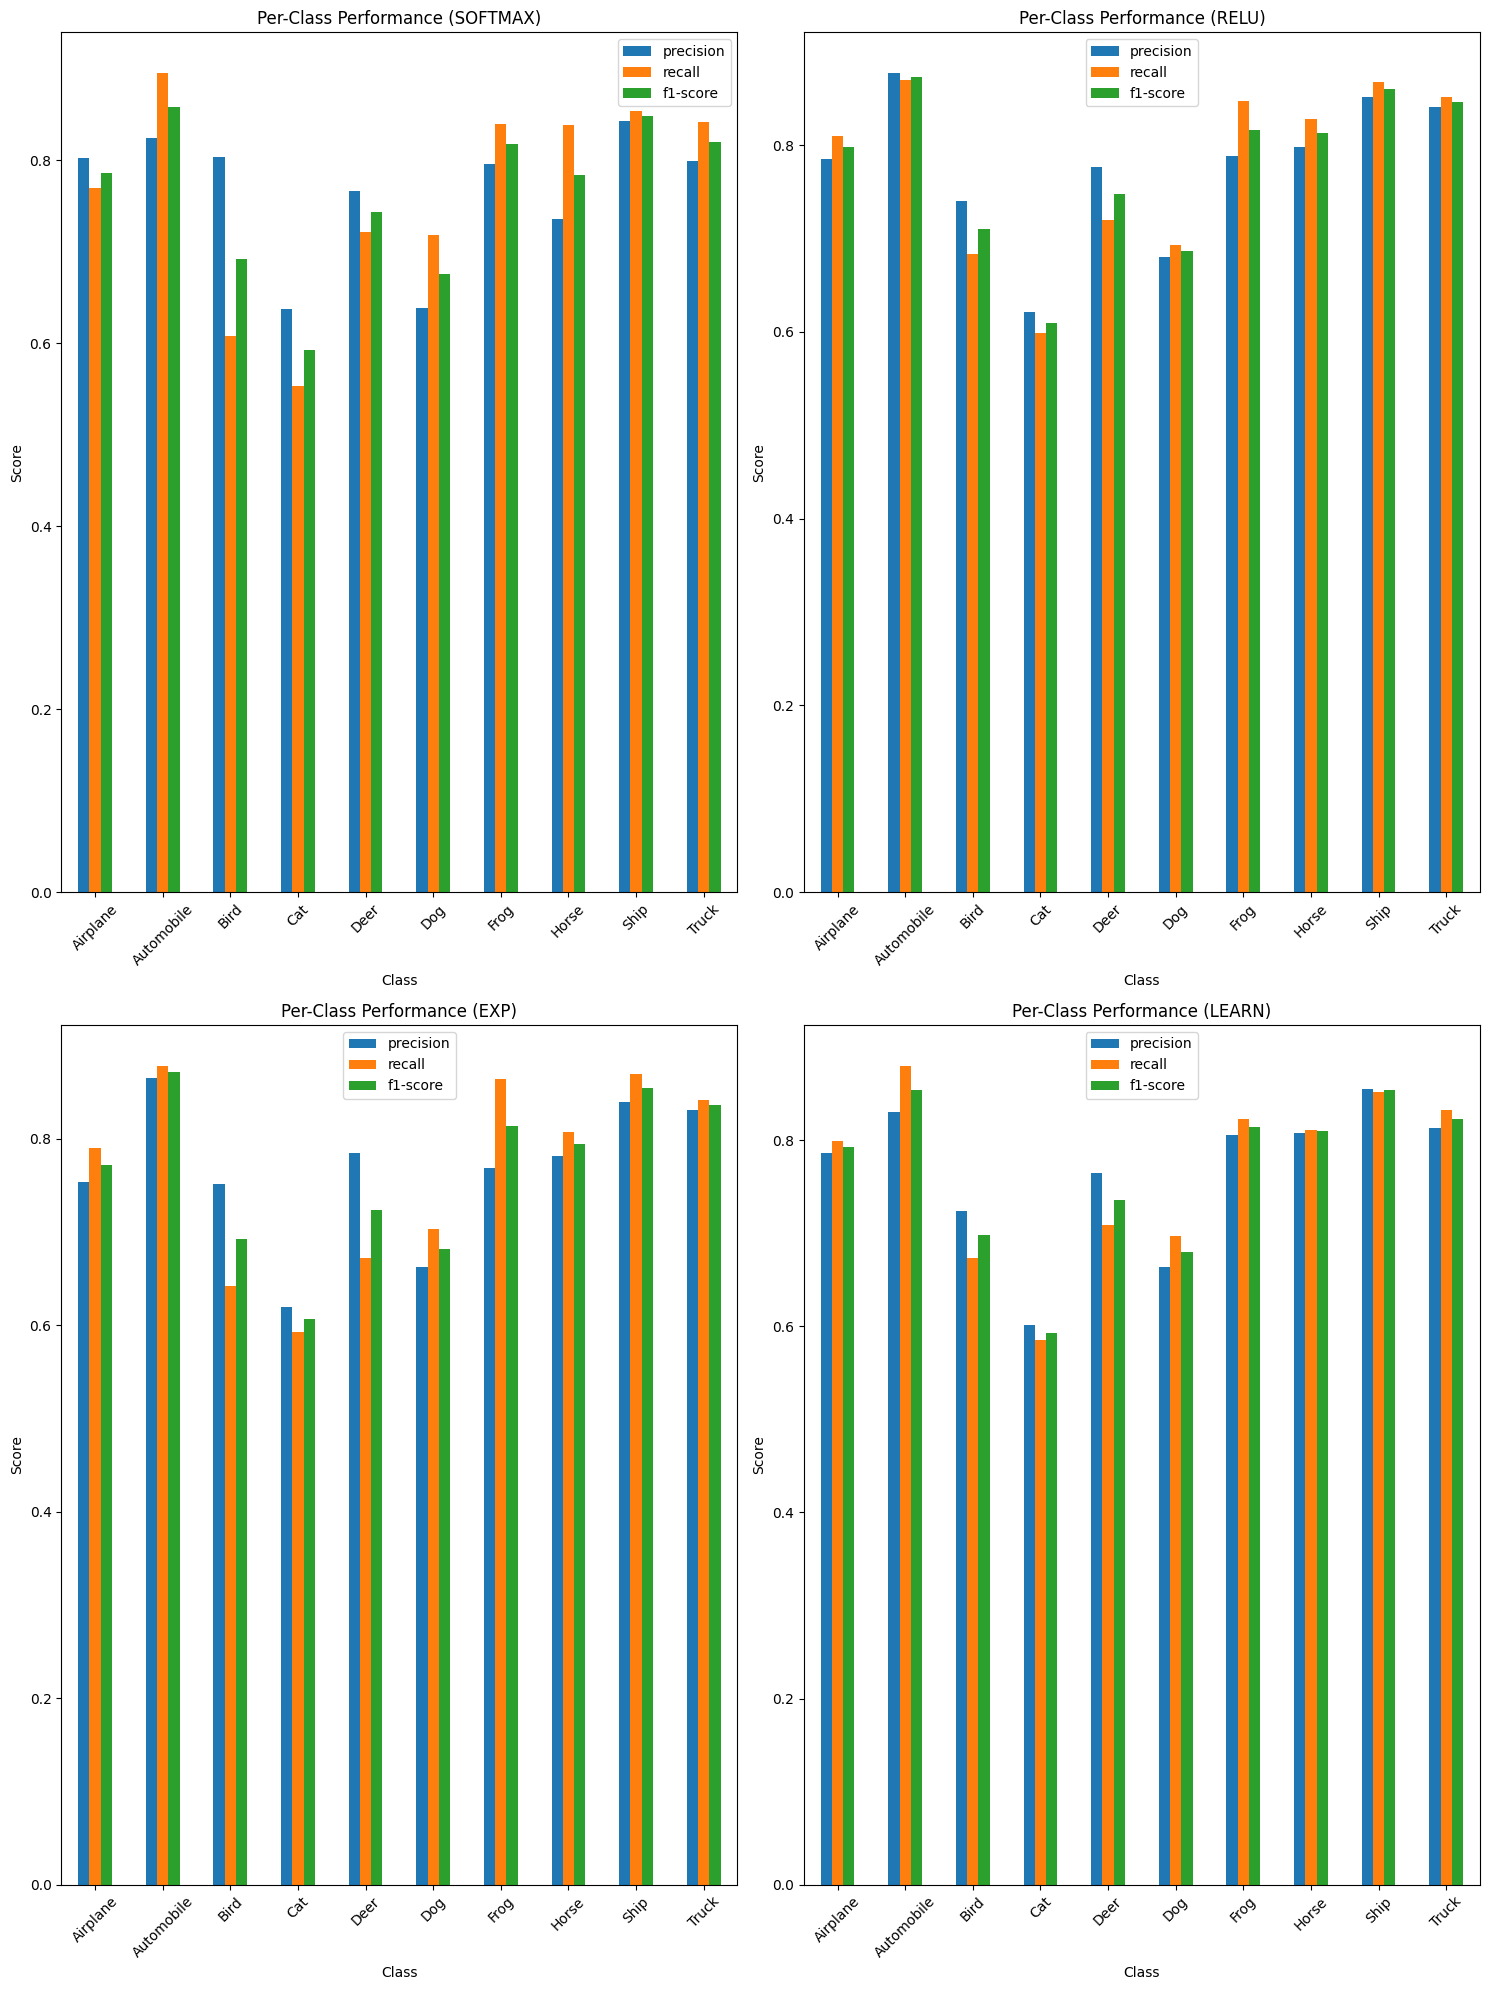

In [94]:
plot_per_class_performance(models=models_cifar10, dataloader=valid_loader, class_names=class_names, device="cpu", figsize=(15, 20))

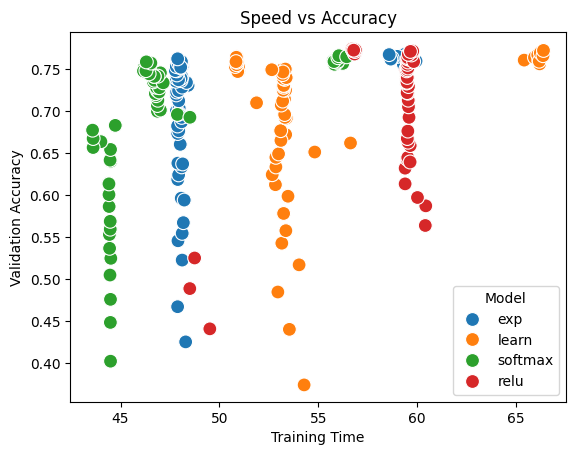

In [95]:
def plot_speed_accuracy(df, dataset_name):
    dataset_df = df[df["Dataset"] == dataset_name]
    sns.scatterplot(
        x="Training Time", y="Validation Accuracy", hue="Model", data=dataset_df, s=100
    )
    plt.title("Speed vs Accuracy")
    plt.show()

plot_speed_accuracy(combined_df, dataset_name="cifar10")

In [96]:
print(image_dir)
images = []

for p in os.listdir(image_dir):
    full_path = os.path.join(image_dir, p)
    if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        print(full_path)
        image = Image.open(full_path).convert('RGB').resize((32, 32))
        images.append(image)

../data/images
../data/images/bird1.jpeg
../data/images/car.jpeg
../data/images/bird.jpg
../data/images/dog.jpeg
../data/images/cat.jpg
../data/images/frog.jpg
../data/images/dog2.jpeg


In [97]:
class_names
class_to_idx = train_set.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [98]:
def get_transforms(image):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    return transform(image)

def classify_with_all_models(models, image, device, class_names):
    predictions = {}
    input_image = get_transforms(image).unsqueeze(0).to(device)  
    with torch.no_grad():
        for model_name, model in models.items():
            model.eval()  
            outputs = model(input_image)
            _, predicted = outputs.max(1) 
            predictions[model_name] = class_names[predicted.item()]
    return predictions

def load_images(image_dir):
    images = []
    for p in os.listdir(image_dir):
        full_path = os.path.join(image_dir, p)
        if p.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image = Image.open(full_path).convert('RGB') 
            images.append(image)
    return images




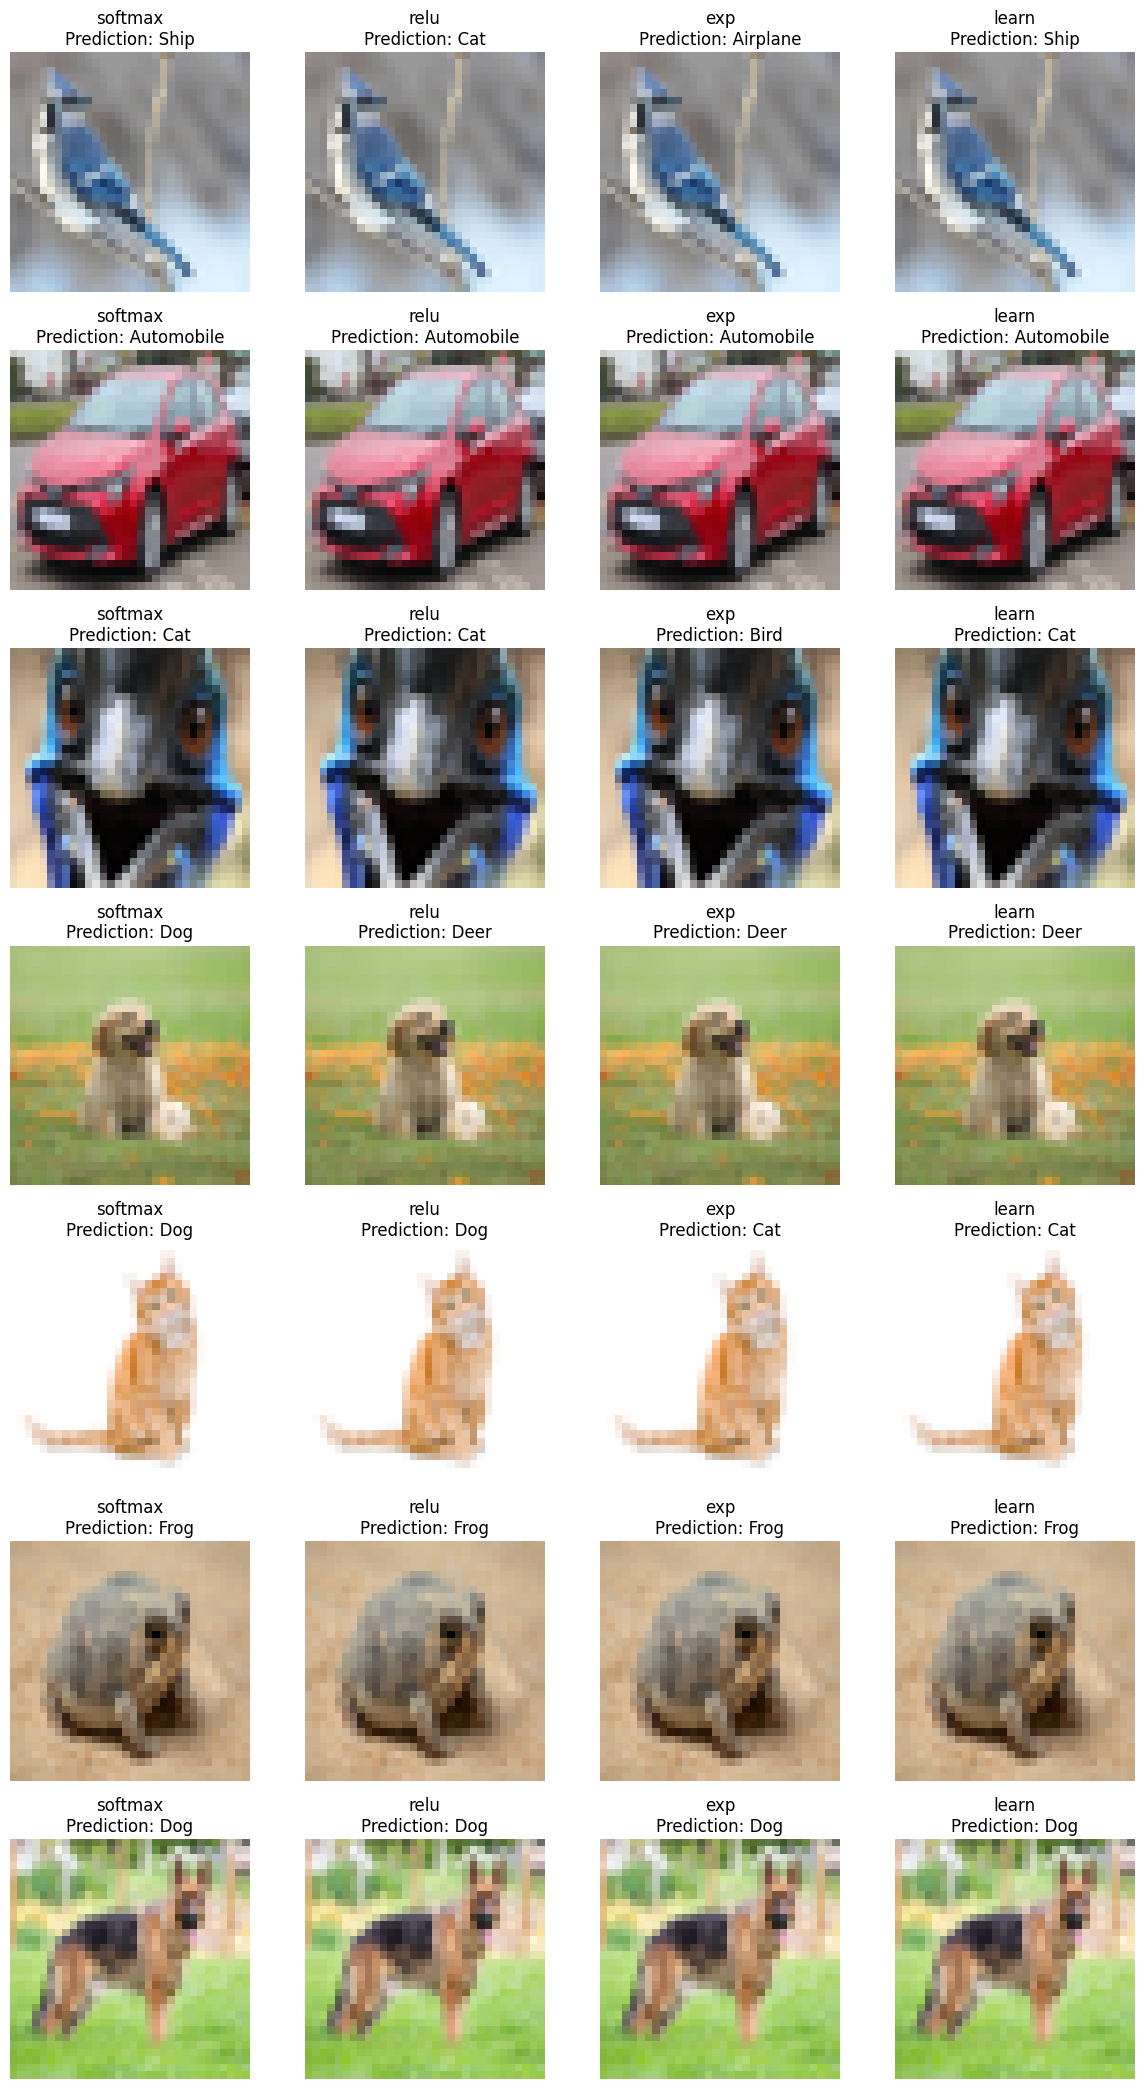

In [99]:
num_images = len(images)
num_models = len(models_cifar10)


fig, axes = plt.subplots(num_images, num_models, figsize=(3 * num_models, 3 * num_images))

for i, image in enumerate(images):
    predictions = classify_with_all_models(models_cifar10, image, 'cpu', class_names)
    for j, (model_name, prediction) in enumerate(predictions.items()):
        ax = axes[i, j] if num_images > 1 else axes[j]
        ax.imshow(image)
        ax.set_title(f'{model_name}\nPrediction: {prediction}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [100]:
# # Initialize an empty list to store individual dataframes
# data_dir = '../data'; dataset_name = 'mnist'; dwn = True

# dataset_dir = f'{data_dir}/{dataset_name}'
# train_dir = f'{dataset_dir}/train'; test_dir = f'{dataset_dir}/test'

# checkpoint_dir = f'{data_dir}/checkpoints'
# log_dir = f'{data_dir}/logs'
# dl_kwargs = dict(shuffle=False, num_workers=0, pin_memory=True) # for the DataLoader

# train_set, test_set, channels, image_size, num_classes = get_data(
#     dataset_name=dataset_name, train_dir=train_dir, test_dir=test_dir, dwn=dwn
# )

# print(f'Channels: {channels}, Image size: {image_size}, Num. classes: {num_classes}.')
# len(train_set), len(test_set)

In [101]:
# mnist_batchsize = 128

# train_loader = DataLoader(dataset=train_set, batch_size=mnist_batchsize, shuffle=False, num_workers=0, pin_memory=True)
# valid_loader = DataLoader(dataset=test_set , batch_size=mnist_batchsize, shuffle=False, num_workers=0, pin_memory=True)

# model_params_cifar10 = {
#     "image_size": image_size,  
#     "patch_size": 7,  
#     "num_classes": num_classes,
#     "dim": 64,
#     "depth": 2,
#     "heads": 2,
#     "mlp_dim": 128,
#     "pool": 'cls',
#     "channels": channels,
#     "dim_head": 64,
#     "dropout": 0.10,
#     "emb_dropout": 0.10,
#     "la_depth": 1, 
#     "la_exp": False,      
# }

# attention_types = ['softmax', 'relu', 'exp', 'learn']

# # Initialize models
# models_mnist = {}
# for attn_type in attention_types:
#     print(f"Initializing model with attention type: {attn_type}")
#     model = load_trained_model(checkpoint_path=checkpoint_dir, model_params=model_params_cifar10, device = 'mps', dataset_name = dataset_name, attn_type = attn_type )
#     models_mnist[attn_type] = model

# print(models_mnist)

In [102]:
# def get_embeddings(model, dataloader, device):
#     model.eval()
#     embeddings, labels = [], []
    
#     with torch.no_grad():
#         for inputs, targets in dataloader:
#             inputs = inputs.to(device)
            
#             # Get patch embeddings: Shape [batch_size, num_patches, dim]
#             patch_embeddings = model.to_patch_embedding(inputs)
            
#             # Flatten embeddings to 2D: Shape [batch_size * num_patches, dim]
#             flattened_embeddings = patch_embeddings.view(-1, patch_embeddings.shape[-1])
            
#             # Repeat labels for each patch
#             repeated_labels = targets.repeat_interleave(patch_embeddings.shape[1])
            
#             embeddings.append(flattened_embeddings.cpu().numpy())
#             labels.append(repeated_labels.numpy())
    
#     embeddings = np.concatenate(embeddings)
#     labels = np.concatenate(labels)
#     return embeddings, labels


# def plot_all_embeddings(models, dataloader, num_classes, device, method='pca', figsize=(20, 20)):
#     fig, axes = plt.subplots(2, 2, figsize=figsize)
#     axes = axes.flatten()

#     for i, (attn_type, model) in enumerate(models.items()):
#         embeddings, labels = get_embeddings(model, dataloader, device)
        
#         if method == 'pca':
#             reducer = PCA(n_components=2)
#         elif method == 'tsne':
#             reducer = TSNE(n_components=2, random_state=42)
#         else:
#             raise ValueError("Invalid method. Use 'pca' or 'tsne'.")
        
#         reduced_embeddings = reducer.fit_transform(embeddings)
        
#         scatter = axes[i].scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
#                                   c=labels, cmap='tab10', alpha=0.7)
#         axes[i].set_title(f'{method.upper()} of Embeddings ({attn_type})')
#         axes[i].set_xlabel('Component 1')
#         axes[i].set_ylabel('Component 2')
#         axes[i].grid(True)
    
#     fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
#     plt.tight_layout()
#     plt.show()

# plot_all_embeddings(
#     models=models_mnist,  
#     dataloader=valid_loader, 
#     num_classes=num_classes,
#     device='cpu',            
#     method='tsne',           
#     figsize=(15, 15)         
# )